#  BPSK Demodulation in Nonlinear Channels with Deep Neural Networks

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* demodulation of BPSK symbols in highly nonlinear channels using an artificial neural network

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib inline 

Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
x_{k+1} = x_k\exp\left(\jmath\frac{L}{K}\gamma|x_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $x_0$ is the channel input (the modulated, complex symbols) and $x_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel Usually $K=50$ gives a good approximation.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," Proc. ECOC, Rome, Sep. 2018

In [2]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 50 # number of steps used in the channel model

def simulate_channel(x, Pin):  
    # modulate bpsk
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = np.sqrt(input_power_linear);
    bpsk = (1 - 2*x) * norm_factor
    

    # noise variance per step    
    sigma = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    

    temp = np.array(bpsk, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        
        temp = temp * np.exp(1j*rotcoff) + sigma*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return temp

We consider BPSK transmission over this channel.

Show constellation as a function of the fiber input power. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

In [14]:
length = 5000

def plot_constellation(Pin):
    t = np.random.randint(2,size=length)
    r = simulate_channel(t, Pin)

    plt.figure(figsize=(6,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=True)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='coolwarm')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation (L = %d km, $P_{in} = %1.2f$\,dBm)' % (L, Pin))    
    plt.savefig('bpsk_received_zd_%1.2f.pdf' % Pin,bbox_inches='tight')
    
interactive_update = interactive(plot_constellation, Pin = widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=1, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')))


output = interactive_update.children[-1]
output.layout.height = '500px'
interactive_update

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input Power Pin (dBm)', lay…

Helper function to plot the constellation together with the decision region. Note that a bit is decided as "1" if $\sigma(\boldsymbol{\theta}^\mathrm{T}\boldsymbol{r}) > \frac12$, i.e., if $\boldsymbol{\theta}^\mathrm{T}\boldsymbol{r}$ > 0. The decision line is therefore given by $\theta_1\Re\{r\} + \theta_2\Im\{r\} = 0$, i.e., $\Im\{r\} = -\frac{\theta_1}{\theta_2}\Re\{r\}$

Generate training, validation and testing data sets

In [15]:
# helper function to compute the bit error rate
def BER(predictions, labels):
    decision = predictions >= 0.5
    return np.mean(decision != labels)

In [16]:
# set input power
Pin = 3

# validation set. Training examples are generated on the fly
N_valid = 100000

# mini-batch size
batch_size = 1000

hidden_neurons_1 = 8
hidden_neurons_2 = 14


y_valid = np.random.randint(2,size=N_valid)
r = simulate_channel(y_valid, Pin)

# find extension of data (for normalization and plotting)
ext_x = max(abs(np.real(r)))
ext_y = max(abs(np.imag(r)))
ext_max = max(ext_x,ext_y)*1.2

# scale data to be between 0 and 1
X_valid = np.column_stack((np.real(r), np.imag(r))) / ext_max


# meshgrid for plotting
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) / ext_max

In [17]:
# generate graph
graph = tf.Graph()

with graph.as_default():    
    # placeholder for training data (passed from externally)
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,2))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size))
    
    # the validation dataset
    tf_valid_dataset = tf.constant(X_valid, dtype=tf.float32)
    tf_valid_labels = tf.constant(y_valid, dtype=tf.float32)

    # the mesgrid for plotting the decision region
    tf_meshgrid = tf.constant(meshgrid, dtype=tf.float32)
    
    # define neural network by hand
    # assume 2 hidden layers with ReLU functions and a logistic output function
    W1 = tf.Variable(tf.truncated_normal([2,hidden_neurons_1], stddev=0.8)) 
    b1 = tf.Variable(tf.truncated_normal([hidden_neurons_1], stddev=0.8))
    
    W2 = tf.Variable(tf.truncated_normal([hidden_neurons_1,hidden_neurons_2], stddev=0.8))
    b2 = tf.Variable(tf.truncated_normal([hidden_neurons_2], stddev=0.8))
    
    W3 = tf.Variable(tf.truncated_normal([hidden_neurons_2,1], stddev=0.8))
    b3 = tf.Variable(tf.truncated_normal([1], stddev=0.8))
    
    def neural_network(inp):
        temp1 = tf.nn.elu(tf.matmul(inp, W1)+b1)
        temp2 = tf.nn.elu(tf.matmul(temp1, W2)+b2)
        # note that the sigmoid is not part of the neural network, but of the loss function later. This saves some complexity        
        # squeeze removes the extra dimension and makes the output scalar
        return tf.squeeze(tf.matmul(temp2, W3)+b3)
    
    #output of the neural network
    logits = neural_network(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))    

    # equivalent formulation without using tensorflow's intern function
    #loss = tf.reduce_mean(-tf_train_labels * tf.log(tf.sigmoid(logits)) - (1-tf_train_labels)*tf.log(1-tf.sigmoid(logits)))
    
    # use Adap optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    
    # predictions for training, validation and test data    
    valid_prediction = tf.nn.sigmoid(neural_network(tf_valid_dataset))
        
    # mesh prediction for plotting
    mesh_prediction = tf.nn.sigmoid(neural_network(tf_meshgrid))

In [21]:
num_epochs = 300
batches_per_epoch = 150

validation_BERs = np.zeros(num_epochs)
decision_region_evolution = []

with tf.Session(graph=graph) as session:
    # initialize variables
    tf.global_variables_initializer().run()

    print('Initialized')
    for epoch in range(num_epochs):
        for step in range(batches_per_epoch):
            # sample new mini-batch 
            batch_labels =  np.random.randint(2,size=batch_size)
            r = simulate_channel(batch_labels, Pin)
            batch_data = np.column_stack((np.real(r), np.imag(r))) / ext_max
                        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels }
            
            # run an optimization step
            _ = session.run(optimizer, feed_dict=feed_dict)
        
        # compute validation BER
        valid_out = valid_prediction.eval()
        validation_BERs[epoch] = BER(valid_out, y_valid)
        print('Validation BER after epoch %d: %f' % (epoch, validation_BERs[epoch]))                
        
        # store decision region for generating the animation
        decision_region_evolution.append(0.195*mesh_prediction.eval() + 0.4)

Initialized
Validation BER after epoch 0: 0.023680
Validation BER after epoch 1: 0.014440
Validation BER after epoch 2: 0.013160
Validation BER after epoch 3: 0.012750
Validation BER after epoch 4: 0.012430
Validation BER after epoch 5: 0.012450
Validation BER after epoch 6: 0.012410
Validation BER after epoch 7: 0.012320
Validation BER after epoch 8: 0.012310
Validation BER after epoch 9: 0.012270
Validation BER after epoch 10: 0.012200
Validation BER after epoch 11: 0.011870
Validation BER after epoch 12: 0.012120
Validation BER after epoch 13: 0.012260
Validation BER after epoch 14: 0.012120
Validation BER after epoch 15: 0.012030
Validation BER after epoch 16: 0.012220
Validation BER after epoch 17: 0.012150
Validation BER after epoch 18: 0.011890
Validation BER after epoch 19: 0.011760
Validation BER after epoch 20: 0.011860
Validation BER after epoch 21: 0.011820
Validation BER after epoch 22: 0.011800
Validation BER after epoch 23: 0.011900
Validation BER after epoch 24: 0.01188

Validation BER after epoch 203: 0.000020
Validation BER after epoch 204: 0.000020
Validation BER after epoch 205: 0.000020
Validation BER after epoch 206: 0.000020
Validation BER after epoch 207: 0.000020
Validation BER after epoch 208: 0.000020
Validation BER after epoch 209: 0.000020
Validation BER after epoch 210: 0.000020
Validation BER after epoch 211: 0.000020
Validation BER after epoch 212: 0.000020
Validation BER after epoch 213: 0.000020
Validation BER after epoch 214: 0.000030
Validation BER after epoch 215: 0.000020
Validation BER after epoch 216: 0.000020
Validation BER after epoch 217: 0.000020
Validation BER after epoch 218: 0.000020
Validation BER after epoch 219: 0.000020
Validation BER after epoch 220: 0.000020
Validation BER after epoch 221: 0.000020
Validation BER after epoch 222: 0.000030
Validation BER after epoch 223: 0.000020
Validation BER after epoch 224: 0.000020
Validation BER after epoch 225: 0.000020
Validation BER after epoch 226: 0.000020
Validation BER a

<IPython.core.display.Javascript object>


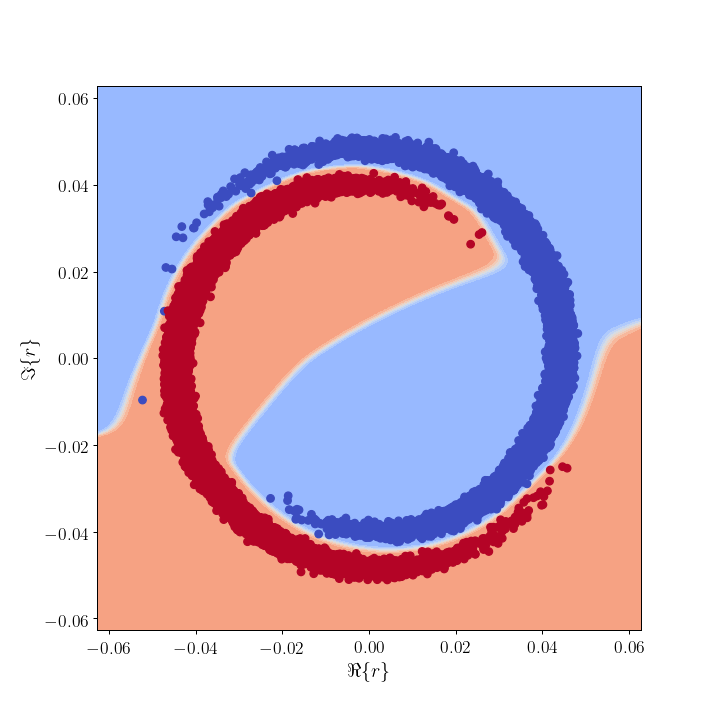

3


Text(0, 0.5, '$\\Im\\{r\\}$')

In [22]:
plt.figure(figsize=(8,8))
plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.695)
plt.scatter(X_valid[:,0]*ext_max, X_valid[:,1] * ext_max, c=y_valid, cmap='coolwarm')
print(Pin)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
#plt.title(title,fontsize=16)
#plt.savefig('after_optimization.pdf',bbox_inches='tight')